# EnKF的不足和相应的经验方法

> 海洋学院，沈浙奇，2024年6月，zqshen@hhu.edu.cn

## 局地化

EnKF的一个主要问题是当问题的变量数目较大的时候，集合成员数不足会造成一些问题。

在集合卡尔曼滤波器（EnKF）中，局地化是一种用于减轻采样误差并改善滤波器在高维系统中的性能的技术。它通过减少远离每个模型网格点的观测对更新的影响来实现。Houtekamer和Mitchell (1998) 首次提出局地化方法。在这篇论文中，他们使用了一种对偶集合卡尔曼滤波器，即运行了一对成员数都为N的集合，在每次同化中都使用一个集合计算的误差协方差来将观测数据同化到另一个集合中。两个EnKF对第一猜测场进行不同的扰动，得到不同的初始集合来估计预测误差和获取分析误差。在这种方案中，他们采用了一种独创的处理方式——使用一个截止半径（cut-off radius）来进行数据筛选。具体来说，对于同一个空间点不同高度上的每一列分析点，他们设定在给定的水平距离r_max以内的所有数据被同化,而r_max以外的所有数据不被同化。这种截止方案在卡尔曼滤波器中并不常见，但在最优插值算法中曾被采用。这种方法可以有效消除与分析点只有微弱相关性的观测数据。而根据Houtekamer和Mitchell（1998）的研究，如果不采用截断半径，这可能需要成千上万的集合成员来准确解决。该论文是集合滤波器中采用局地化的最初尝试。

Houtekamer和Mitchell （2001）引入了一种集合预报误差的局地化方法。该方法主要用于滤去较小集合导致的预报场和误差的微小相关——这些相关并不是实际存在的，而是由于欠采样问题所导致的虚假相关。这些微小的虚假相关可能会影响预报误差协方差的准确性。他们通过应用舒尔（Shur）乘积（也被称为Hadamard乘积，是一个逐元素的矩阵乘积）来实现这种局地化，该乘积是由集合计算的预报误差协方差和具有局部支集的相关函数组成的。

具体来说，Houtekamer和Mitchell（2001）将集合卡尔曼增益矩阵K重新定义为

$$K=((\rho \circ P^f)H^T)[H(\rho \circ P^f)H^T+R]^{-1}           $$

其中$\rho$被称为局地化矩阵，通过与预报误差协方差$P^f$的舒尔乘积来消除远距离的虚假相关。通过互换观测投影和舒尔乘积的顺序，也可以得到

$$K=(\rho \circ(P^f H^T))[ρ∘(HP^f H^T)+R]^{-1}            $$

其中，
$$ P_k^f H^T\equiv \frac{1}{N-1} \sum_{i=1}^N(x_{k,i}^f-\bar{x}_k^f)  [h(x_{k,i}^f)-h(\bar{x}_k^f) ]^T ）$$
$$ HP_k^f H^T\equiv \frac{1}{N-1} \sum_{i=1}^N[h(x_{k,i}^f)-h(\bar{x}_k^f) ] [h(x_{k,i}^f)-h(\bar{x}_k^f) ]^T    $$


矩阵$\rho$的一般使用一些具备特殊性质的相关函数来生成，相关函数的选择比较宽泛。在Houtekamer和Mitchell（2001）中，他们使用了一个五阶紧支集的分段有理函数，该函数来自Gaspri和Cohn（1999）的文章，也被称为Gaspri-Cohn函数（G-C函数），其函数表达式如下：

$$
\Omega(d ; c)= \begin{cases}-\frac{1}{4}\left(\frac{d}{c}\right)^5+\frac{1}{2}\left(\frac{d}{c}\right)^4+\frac{5}{8}\left(\frac{d}{c}\right)^3-\frac{5}{3}\left(\frac{d}{c}\right)^2+1, & 0 \leq d \leq c \\ \frac{1}{12}\left(\frac{d}{c}\right)^5-\frac{1}{2}\left(\frac{d}{c}\right)^4+\frac{5}{8}\left(\frac{d}{c}\right)^3+\frac{5}{3}\left(\frac{d}{c}\right)^2-5\left(\frac{d}{c}\right)+4-\frac{2}{3}\left(\frac{d}{c}\right)^{-1}, & c \leq d \leq 2 c \\ 0, & d \geq 2 c\end{cases}
$$

其中$d=‖x-y‖$为模式变量和观测的距离，c是一个控制参数。可以发现其数值随着模式变量与观测的距离的增加而光滑衰减，且在距离超过2c之后衰减为0。G-C函数是具有紧支集的函数——即超过一定距离（这里是2c）后，其数值变为0。紧支性的优点在于它可以完全消除一定距离以外的变量相关，而且c是一个可以调整的局地化参数，能够有效控制变量的影响范围。

下面这个图可以说明一点儿局地化的必要性。左边代表我们要表示的真实误差协方差矩阵，其他三个分别是使用30个、300个和300个集合成员计算的误差协方差矩阵。可以看出在集合成员很少的情况下，即使很远的点，也会有一些相关性，而这些相关是虚假的，完全是由于集合成员不足造成的。当使用3000个成员时，这种远距离的虚假相关就不明显了。在实际无法增加集合成员的前提下，可以人工地去掉这种虚假相关，使用的方法就是局地化。

<img src="pic/Localization1.png" alt="Localization1" style="zoom:50%;" />

下图是采用30个集合成员的近似误差协方差矩阵，作用上局地化后的结果。可以看出，作用参数$c=1$的局地化之后，虽然相关的强度还是有差异，但是至少没有虚假的远距离相关了。这就意味着一个点的观测不会以一种非常随机的方式影响远距离的变量，相对来说，不会造成非常离谱的同化效果。

<img src="pic/Localization2.png" alt="Localization2" style="zoom:60%;" />

### Lorenz 96模式

由于Lorenz 63模式只包含三个变量，且没有位置和距离的概念，因此我们使用另外一个模式来说明局地化在EnKF中的影响。

Lorenz 96模式（L96）模式被广泛用于数据同化的理论研究中。L96最初由Lorenz（1996）提出，用来模拟一个非特别指定的气象变量的多尺度中纬度大气动力过程。一个纬度圈被划分为K=36个扇区，每个扇区中的变量$X_j$跨越10个经度，且由下列方程控制，

$$\frac{dX_j}{dt}=(X_{j+1}-X_{j-2} ) X_{j-1}-X_j+F, \quad  i=1,…,36,         $$

该方程应用循环边界条件，即$X_{-1}=X_{35}$, $X_0=X_{36}$, 以及$X_1=X_{37}$。按照Lorenz和Emanuel（1998）的方法，该模型采用四阶Runge-Kutta方案，时间步长为0.01个无量纲时间单位（TUs）。外强迫$F$被固定为8.0，这使得模型呈现混沌行为。在$F=8$的情况下，就系统的误差增长率而言，单位时间对应于5天。

以下代码首先提供了L96模式的代码及实验设置，然后提供了真值积分和造观测过程。除了模式的定义不同之外，其他流程和L63模式的实验是非常类似的。L96模式有36个变量，积分步长0.01大约相当于1.2个小时，同化间隔为20步，即每天同化一次。观测算子设置为每四个变量观测一个，即每40个经度有一个观测。通过孪生实验，我们用L96模式探讨局地化在EnKF同化中的重要性。

In [1]:
# Lorenz 96模式方程
import numpy as np
def Lorenz96(state,*args):                     # 定义Lorenz 96 模式右端项
    x = state                                  # 模式状态记为x
    F = args[0]                                # 输入外强迫
    n = len(x)                                 # 状态空间维数
    f = np.zeros(n)                          
    f[0] = (x[1] - x[n-2]) * x[n-1] - x[0]     # 处理三个边界点: i=0,1,N-1
    f[1] = (x[2] - x[n-1]) * x[0] - x[1]       # 导入周期边界条件
    f[n-1] = (x[0] - x[n-3]) * x[n-2] - x[n-1]
    for i in range(2, n-1):                  
        f[i] = (x[i+1] - x[i-2]) * x[i-1] - x[i] # 内部点符合方程
    f = f + F                                    # 加上外强迫
    return f

In [2]:
def RK4(rhs,state,dt,*args):                    # 使用Runge-Kutta方法求解（同L63）
    k1 = rhs(state,*args)
    k2 = rhs(state+k1*dt/2,*args)
    k3 = rhs(state+k2*dt/2,*args)
    k4 = rhs(state+k3*dt,*args)
    new_state = state + (dt/6)*(k1+2*k2+2*k3+k4)
    return new_state

然后，使用`x1 = RK4(Lorenz96,x0,dt,F)`可以以$dt$的步长和$F$的外强迫积分模式。如果设置$X$有36个变量，那么可以假设只有部分变量能被观测到，比如只观测9个变量。这可以通过设置观测矩阵实现。此外，我们最好先积分一段时间，使得变量之间建立一定的相关性，这个过程叫自旋（spin-up），其实也就是自由积分一段较长的时间。

In [3]:
def h(x):                                         # 观测算子(假设只观测部分变量)
    n= x.shape[0]                                # 状态维数
    m= 9                                       # 总观测数
    H = np.zeros((m,n))                           # 设定观测算子
    di = int(n/m)                                 # 两个观测之间的空间距离
    for i in range(m):
        H[i,(i+1)*di-1] = 1                        # 通过设置观测位置给出观测矩阵
    z = H @ x                                   # 左乘观测矩阵得到观测算子
    return z

In [4]:
n = 36                      # 状态空间维数
F = 8                       # 外强迫项
dt = 0.01                   # 积分步长
# spinup获取真实场初值: 从 t=-20 积分到 t = 0 以获取实验初值
x0 = F * np.ones(n)         # 初值
x0[19] = x0[19] + 0.01      # 在第20个变量上增加微小扰动
x0True = x0
nt1 = int(20/dt)
for k in range(nt1):
    x0True = RK4(Lorenz96,x0True,dt,F)   #从t=-20积分到t=0
# 造真值和观测 
tm = 20                     # 实验窗口长度
nt = int(tm/dt)             # 积分步数
t = np.linspace(0,tm,nt+1)
np.random.seed(seed=1)
m = 9                       # 观测变量数
dt_m = 0.2                  # 两次观测之间的时间
tm_m = 20                   # 最大观测时间
nt_m = int(tm_m/dt_m)       # 同化次数
ind_m = (np.linspace(int(dt_m/dt),int(tm_m/dt),nt_m)).astype(int)
t_m = t[ind_m]
# --------
sig_m= 0.1                  # 观测误差标准差
R = sig_m**2*np.eye(m)      # 观测误差协方差
# --------
Xtrue = np.zeros([n,nt+1])
Xtrue[:,0] = x0True
km = 0
yo = np.zeros([m,nt_m])
for k in range(nt):
    Xtrue[:,k+1] = RK4(Lorenz96,Xtrue[:,k],dt,F)    # 真值
    if (km<nt_m) and (k+1==ind_m[km]):
        yo[:,km] = h(Xtrue[:,k+1]) + np.random.normal(0,sig_m,[m,])  # 加噪声得到观测
        km = km+1

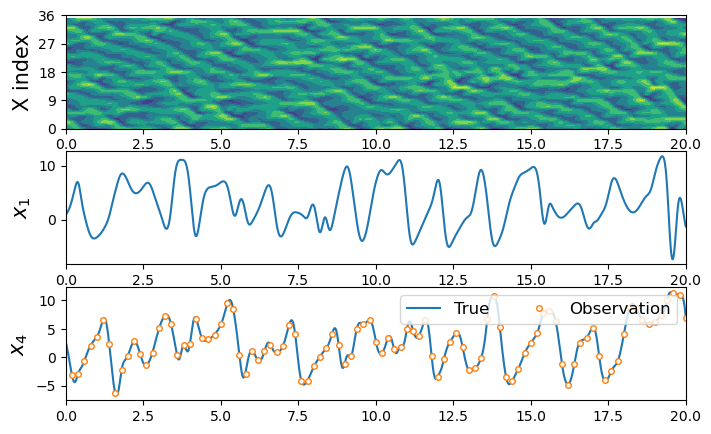

In [5]:
import matplotlib.pyplot as plt
tt,xx = np.meshgrid(range(36),t)    # 2维画图网格
plt.figure(figsize=(8,5))
plt.subplot(3,1,1)
plt.contourf(xx,tt,Xtrue.T)
plt.ylabel('X index',fontsize=15);plt.yticks(np.arange(0,37,9))
plt.subplot(3,1,2)
plt.plot(t,Xtrue[0,:],label='True')
plt.xlim(0,20);plt.ylabel(r'$x_1$',fontsize=15)
plt.subplot(3,1,3)
plt.plot(t,Xtrue[3,:],label='True')
plt.plot(t_m,yo[0,:],'o',ms=4,markerfacecolor='white',label='Observation')
plt.xlim(0,20);plt.ylabel(r'$x_4$',fontsize=15)
plt.legend(ncol=2,loc='upper right', fontsize=12)

第一行是真实值的时空分布，然后下面两个图分别是没有被观测到的变量$X_1$和被观测到的变量$X_4$的时间演变。然后就可以开始用sEAKF进行同化实验了。

In [6]:
#%% （串行）集合调整卡尔曼滤波器
def obs_increment_eakf(ensemble, observation, obs_error_var): # 1：计算观测空间增量
    prior_mean = np.mean(ensemble);
    prior_var = np.var(ensemble);
    if prior_var >1e-6:                                                 # 用于避免退化的先验集合造成错误更新
        post_var = 1.0 / (1.0 / prior_var + 1.0 / obs_error_var);       # 公式（2）
        post_mean = post_var * (prior_mean / prior_var + observation / obs_error_var);  # 公式（3）
    else:
        post_var = prior_var; post_mean = prior_mean;    
    updated_ensemble = ensemble - prior_mean + post_mean;
    var_ratio = post_var / prior_var;
    updated_ensemble = np.sqrt(var_ratio) * (updated_ensemble - post_mean) + post_mean; # 公式（4）
    obs_increments = updated_ensemble - ensemble;
    return obs_increments
def get_state_increments(state_ens, obs_ens, obs_incs): # 2将观测增量回归到状态增量
    covar = np.cov(state_ens, obs_ens);
    state_incs = obs_incs * covar[0,1]/covar[1,1];
    return state_incs
def sEAKF(xai,yo,ObsOp, R, RhoM):
    n,N = xai.shape;                  # 状态维数
    m = yo.shape[0];                  # 观测数
    Loc = ObsOp(RhoM)                 # 观测空间局地化
    for i in range(m):                # 针对每个标量观测的循环
        hx = ObsOp(xai);              # 投影到观测空间 
        hxi = hx[i];                  # 投影到对应的矢量观测
        obs_inc = obs_increment_eakf(hxi,yo[i],R[i,i]);
        for j in range(n):            # 针对状态变量的每个元素的循环
            state_inc = get_state_increments(xai[j], hxi,obs_inc)   # 获取状态增量
            cov_factor=Loc[i,j]       # 使用局地化矩阵的相应元素
            if cov_factor>1e-6:       # 在局地化范围内加增量
                xai[j]=xai[j]+cov_factor*state_inc; 
    return xai

如果使用30个集合成员，但是不加入局地化，直接同化，我们看看同化结果。

In [7]:
sig_b= 1
x0b = x0True + np.random.normal(0,sig_b,[n,])         # 初值，和真值相比差了一个随机扰动
B = sig_b**2*np.eye(n)                                # 初始误差协方差
sig_p= 0.1
Q = sig_p**2*np.eye(n)                                # 模式误差

Xb = np.zeros([n,nt+1]); Xb[:,0] = x0b
for k in range(nt):
    Xb[:,k+1] = RK4(Lorenz96,Xb[:,k],dt,F)                          # 控制实验

N = 30                                                              # 集合成员数
xai = np.zeros([n,N])
for i in range(N):
    xai[:,i] = x0b + np.random.multivariate_normal(np.zeros(n), B)  # 初始集合 

Xa = np.zeros([n,nt+1]); Xa[:,0] = x0b
km = 0
for k in range(nt):
    for i in range(N):                                              # 集合预报
        xai[:,i] = RK4(Lorenz96,xai[:,i],dt,F) \
                 + np.random.multivariate_normal(np.zeros(n), Q)    # 模式积分
    Xa[:,k+1] = np.mean(xai,1)
    if (km<nt_m) and (k+1==ind_m[km]):                              # 开始同化
        xai = sEAKF(xai,yo[:,km],h,R,np.ones([36,36]))              # 如果不使用局地化
        Xa[:,k+1] = np.mean(xai,1)    
        km = km+1

/var/folders/7t/1pgzjvcn36gcz8m3mx1cvmjm0000gn/T/ipykernel_4179/2018298322.py:8: RuntimeWarning: overflow encountered in scalar multiply
  f[0] = (x[1] - x[n-2]) * x[n-1] - x[0]     # 处理三个边界点: i=0,1,N-1
/var/folders/7t/1pgzjvcn36gcz8m3mx1cvmjm0000gn/T/ipykernel_4179/2018298322.py:9: RuntimeWarning: overflow encountered in scalar multiply
  f[1] = (x[2] - x[n-1]) * x[0] - x[1]       # 导入周期边界条件
/var/folders/7t/1pgzjvcn36gcz8m3mx1cvmjm0000gn/T/ipykernel_4179/2018298322.py:10: RuntimeWarning: overflow encountered in scalar multiply
  f[n-1] = (x[0] - x[n-3]) * x[n-2] - x[n-1]
/var/folders/7t/1pgzjvcn36gcz8m3mx1cvmjm0000gn/T/ipykernel_4179/2018298322.py:12: RuntimeWarning: overflow encountered in scalar multiply
  f[i] = (x[i+1] - x[i-2]) * x[i-1] - x[i] # 内部点符合方程
/var/folders/7t/1pgzjvcn36gcz8m3mx1cvmjm0000gn/T/ipykernel_4179/2018298322.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  f[0] = (x[1] - x[n-2]) * x[n-1] - x[0]     # 处理三个边界点: i=0,1,N-1
/var/folders/7t/1pgzjv

运行得都报错了，肯定效果不太好，我们不如看一下RMSE。一看果然误差爆表了，都出现NaN值了。

/var/folders/7t/1pgzjvcn36gcz8m3mx1cvmjm0000gn/T/ipykernel_4179/1112792817.py:2: RuntimeWarning: overflow encountered in square
  RMSEa = np.sqrt(np.mean((Xa-Xtrue)**2,0))


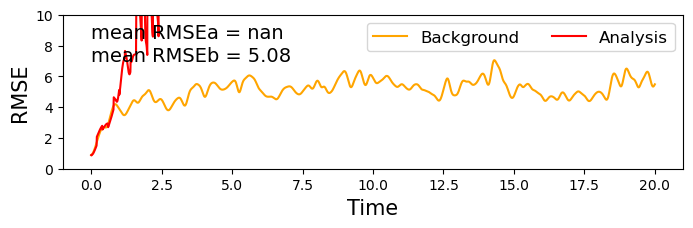

In [8]:
RMSEb = np.sqrt(np.mean((Xb-Xtrue)**2,0))
RMSEa = np.sqrt(np.mean((Xa-Xtrue)**2,0))
plt.figure(figsize=(8,2))
plt.plot(t,RMSEb,color='orange',label='Background')
plt.plot(t,RMSEa,color='red',label='Analysis')
plt.ylim(0,10)
plt.text(0,7,'mean RMSEb = %0.2f' %np.mean(RMSEb),fontsize=14)
plt.text(0,8.5,'mean RMSEa = %0.2f' %np.mean(RMSEa),fontsize=14)
plt.ylabel('RMSE',fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.legend(ncol=2, loc='upper right',fontsize=12)

所以我们要再加上一些局地化涉及的程序，如GC函数，如下：

In [9]:
def comp_cov_factor(z_in,c):
    z=abs(z_in);             # 输入距离和局地化参数，输出局地化因子的数值
    if z<=c:                # 分段函数的各个条件
        r = z/c;
        cov_factor=((( -0.25*r +0.5)*r +0.625)*r -5.0/3.0)*r**2 + 1.0;
    elif z>=c*2.0:
        cov_factor=0.0;
    else:
        r = z / c;
        cov_factor = ((((r/12.0 -0.5)*r +0.625)*r +5.0/3.0)*r -5.0)*r + 4.0 - 2.0 / (3.0 * r);
    return cov_factor

def Rho(localP,size):
    from scipy.linalg import toeplitz
    rho0 = np.zeros(size)
    for j in range(size):
        rho0[j]=comp_cov_factor(j,localP)
    Loc = toeplitz(rho0,rho0) 
    return Loc

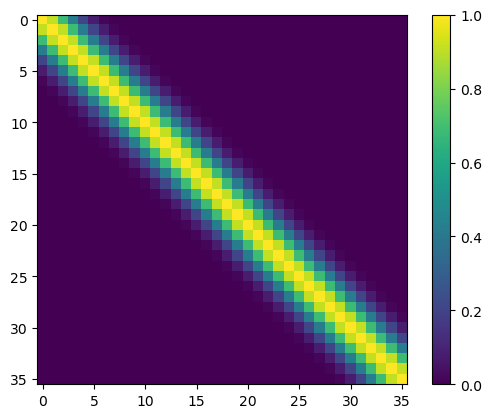

In [10]:
localP = 4; rhom = Rho(localP ,n)        # 产生局地化矩阵
plt.imshow(rhom);plt.colorbar()

这里我们产生了一个局地化矩阵，并看看它的作用。可以看出，主对角线的值为1，然后随着远离主对角线，数值越来越小，直到距离>7的时候彻底为0。我们把这个局地化矩阵放到同化代码中去。然后看同化效果如下：

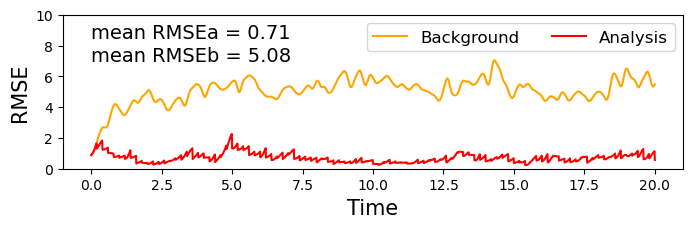

In [11]:
N = 30                                                              # 集合成员数
xai = np.zeros([n,N])
for i in range(N):
    xai[:,i] = x0b + np.random.multivariate_normal(np.zeros(n), B)  # 初始集合 

Xa = np.zeros([n,nt+1]); Xa[:,0] = x0b
km = 0
for k in range(nt):
    for i in range(N):                                              # 集合预报
        xai[:,i] = RK4(Lorenz96,xai[:,i],dt,F) \
                 + np.random.multivariate_normal(np.zeros(n), Q)    # 模式积分
    Xa[:,k+1] = np.mean(xai,1)
    if (km<nt_m) and (k+1==ind_m[km]):                              # 开始同化
        xai = sEAKF(xai,yo[:,km],h,R,rhom)                          # 使用了上述参数为7的局地化
        Xa[:,k+1] = np.mean(xai,1)    
        km = km+1
#%%
RMSEb = np.sqrt(np.mean((Xb-Xtrue)**2,0))
RMSEa = np.sqrt(np.mean((Xa-Xtrue)**2,0))
plt.figure(figsize=(8,2))
plt.plot(t,RMSEb,color='orange',label='Background')
plt.plot(t,RMSEa,color='red',label='Analysis')
plt.ylim(0,10)
plt.text(0,7,'mean RMSEb = %0.2f' %np.mean(RMSEb),fontsize=14)
plt.text(0,8.5,'mean RMSEa = %0.2f' %np.mean(RMSEa),fontsize=14)
plt.ylabel('RMSE',fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.legend(ncol=2, loc='upper right',fontsize=12)

结果变得比较可以接受了，那么我们不妨看看具体误差分布如下：

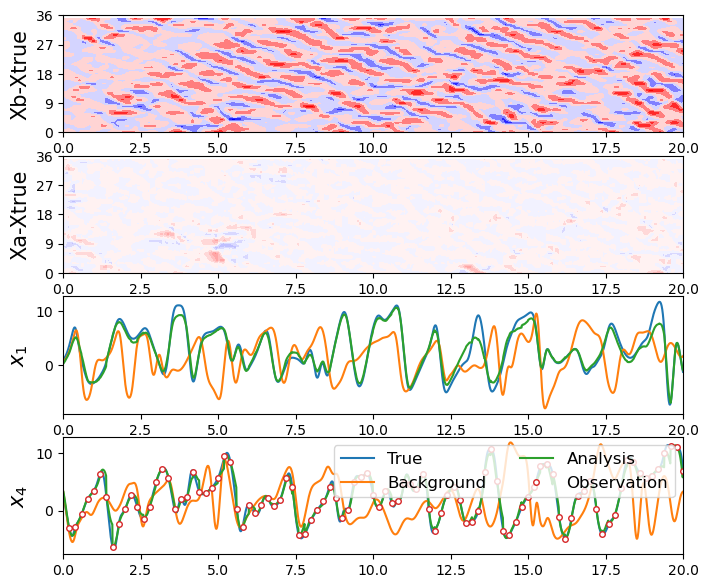

In [12]:
plt.figure(figsize=(8,7))
plt.subplot(4,1,1)
plt.contourf(xx,tt,(Xtrue-Xb).T,cmap='bwr');plt.clim(-15,15);
plt.yticks(np.arange(0,37,9))
plt.ylabel('Xb-Xtrue',fontsize=15)

plt.subplot(4,1,2)
plt.contourf(xx,tt,(Xtrue-Xa).T,cmap='bwr');plt.clim(-15,15);
plt.yticks(np.arange(0,37,9))
plt.ylabel('Xa-Xtrue',fontsize=15)

plt.subplot(4,1,3)
plt.plot(t,Xtrue[0,:],label='True')
plt.plot(t,Xb[0,:],label='Background')
plt.plot(t,Xa[0,:],label='Analysis')
plt.xlim(0,20);plt.ylabel(r'$x_1$',fontsize=15)
plt.subplot(4,1,4)
plt.plot(t,Xtrue[3,:],label='True')
plt.plot(t,Xb[3,:],label='Background')
plt.plot(t,Xa[3,:],label='Analysis')
plt.plot(t_m,yo[0,:],'o',ms=4,markerfacecolor='white',label='Observation')
plt.xlim(0,20);plt.ylabel(r'$x_4$',fontsize=15)
plt.legend(ncol=2,loc='upper right', fontsize=12)

哪怕是没有观测的变量，也可以通过同化改进。

我们发现对于36个变量的Lorenz96模式来说，如果不加上局地化，同化效果是完全不可接受的。而加入局地化之后，同化效果就变得比较正常了。这个和使用30个集合成员计算的$P$矩阵的秩有关，从全局来看，$P$矩阵的秩低于30，肯定是一个奇异矩阵，对其直接求逆会造成问题。而如果使用局地化，每一次的分析相当于在一个子空间内进行，$\rho\circ P$不至于成为奇异矩阵，反而能够有效更新。

对于较大的模式来说，局地化肯定是一个非常重要的工具，不然同化是无法进行的。
而具体的局地化参数如何选取，也是一个问题。以本文中的例子来说，使用不同的局地化参数，同化的效果肯定是不同的。并且，如果集合成员数不一样，最优的局地化参数也会不相同，这些都是需要使用经验的方法确定。而客观的自适应局地化方案，这些就是非常前沿的课题了。

## 后记
本段着重介绍的L96模式，和前面用的L63模式类似，都是同化方法研究的主要测试模型。后面介绍一些方法的时候还会不时用到。